<a href="https://colab.research.google.com/github/Nabin15/Project/blob/main/Final_Project_BILSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive and Install Required Packages
from google.colab import drive
drive.mount('/content/drive')

# Install any required packages
!pip install --upgrade scikit-learn

# Imports & Reproducibility
import os, re, unicodedata, random, string, time
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, SpatialDropout1D, Bidirectional, LSTM,
                                     GlobalMaxPooling1D, GlobalAveragePooling1D,
                                     Dense, Dropout, Input, Concatenate, Conv1D)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# For model size calculation
import pickle
import tempfile

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# 1) Load CSVs
# Adjust paths if needed:
TRAIN_CSV = '/content/drive/MyDrive/Project_Intent/banking77_train.csv'
TEST_CSV  = '/content/drive/MyDrive/Project_Intent/banking77_test.csv'

TEXT_COL = "text"
LABEL_COL = "category"

print("Loading datasets...")
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Number of unique classes: {train_df[LABEL_COL].nunique()}")

# 2) Minimal cleaning
def clean_text(s: str) -> str:
    s = unicodedata.normalize("NFKC", str(s)).lower()
    s = (s.replace("’","'").replace("‘","'").replace("“",'"').replace("”",'"')
           .replace("–","-").replace("—","-").replace("…","..."))
    s = s.replace("£"," gbp ").replace("€"," eur ").replace("$"," usd ")
    s = re.sub(r"(https?://\S+|www\.\S+)", " <url> ", s)
    s = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", " <email> ", s)
    return re.sub(r"\s+", " ", s).strip()

print("Cleaning text data...")
train_df["clean_text"] = train_df[TEXT_COL].astype(str).apply(clean_text)
test_df["clean_text"]  = test_df[TEXT_COL].astype(str).apply(clean_text)

# 3) Encode labels (fit on TRAIN only)
le = LabelEncoder()
y_all_train = le.fit_transform(train_df[LABEL_COL].astype(str))
y_test      = le.transform(test_df[LABEL_COL].astype(str))
num_classes = len(le.classes_)

print(f"Number of classes: {num_classes}")

# 4) Stratified train/val split on CLEAN texts
x_train_texts, x_val_texts, y_train, y_val = train_test_split(
    train_df["clean_text"].tolist(),
    y_all_train,
    test_size=0.10,
    stratify=y_all_train,
    random_state=SEED
)
x_test_texts = test_df["clean_text"].tolist()

print(f"Train samples: {len(x_train_texts)}")
print(f"Validation samples: {len(x_val_texts)}")
print(f"Test samples: {len(x_test_texts)}")

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 62.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Loading datasets...
Train shape: (10003, 2)
Test shape: (3080, 2)
Number of unique classes: 77
Cleaning text data...
Number of classes: 77
Train samples: 9002
Validation samples: 1001
Test samples: 3080


**FIRST STAGE**

In [2]:
# 5) Tokenize & Pad
vocab_size_v1 = 8000  # Small vocabulary
tok_v1 = Tokenizer(num_words=vocab_size_v1, oov_token="<OOV>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # Basic filters
tok_v1.fit_on_texts(x_train_texts)

def to_padded_v1(texts):
    seq = tok_v1.texts_to_sequences(texts)
    maxlen_v1 = 25  # Short fixed length
    return pad_sequences(seq, maxlen=maxlen_v1, padding="post", truncating="post"), maxlen_v1

print("Tokenizing and padding sequences...")
x_train_v1, maxlen_v1 = to_padded_v1(x_train_texts)
x_val_v1,   _         = to_padded_v1(x_val_texts)
x_test_v1,  _         = to_padded_v1(x_test_texts)

y_train_oh_v1 = to_categorical(y_train, num_classes)
y_val_oh_v1   = to_categorical(y_val,   num_classes)
y_test_oh_v1  = to_categorical(y_test,  num_classes)

Tokenizing and padding sequences...


In [3]:
# 6) Char-level preprocessing
print("Preparing character-level inputs...")
CHARS = list(string.ascii_lowercase + string.digits + " ")  # Limited character set
char_to_id = {c: i+1 for i, c in enumerate(CHARS)}  # 0 = pad
max_char_len = 40  # Shorter character sequences

def texts_to_char_ids(texts, maxlen=max_char_len):
    arr = np.zeros((len(texts), maxlen), dtype="int32")
    for i, s in enumerate(texts):
        s = str(s).lower()
        ids = [char_to_id.get(ch, 0) for ch in s[:maxlen]]
        arr[i, :len(ids)] = ids
    return arr

Xtr_char = texts_to_char_ids(x_train_texts)
Xva_char = texts_to_char_ids(x_val_texts)
Xte_char = texts_to_char_ids(x_test_texts)

Preparing character-level inputs...


In [4]:
# 7) Build Word+Char BiLSTM Model
print("Building Word+Char BiLSTM model...")

# Word branch (smaller)
word_in = Input(shape=(maxlen_v1,), dtype="int32")
w = Embedding(vocab_size_v1, 64, mask_zero=True)(word_in)  # Smaller embedding
w = SpatialDropout1D(0.20)(w)
w = Bidirectional(LSTM(32, return_sequences=True, dropout=0.15, recurrent_dropout=0.10))(w)  # Smaller LSTM
w = GlobalMaxPooling1D()(w)

# Char branch (simpler)
char_in = Input(shape=(max_char_len,), dtype="int32")
c = Embedding(len(char_to_id)+1, 16)(char_in)  # Smaller embedding
c = Conv1D(32, kernel_size=3, padding="same", activation="relu")(c)  # Smaller conv
c = GlobalMaxPooling1D()(c)

# Fuse + classifier (simpler)
h = Concatenate()([w, c])
h = Dropout(0.30)(h)
h = Dense(64, activation="relu")(h)  # No regularization
h = Dropout(0.20)(h)
out = Dense(num_classes, activation="softmax")(h)  # No regularization

model_char_bilstm = Model([word_in, char_in], out)

# Compile model with basic settings
model_char_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Higher LR
    loss="categorical_crossentropy",  # No label smoothing
    metrics=["accuracy"]
)

Building Word+Char BiLSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [5]:
#8) Training with Time Measurement
print("Starting training...")

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=1, min_lr=1e-4, verbose=1),  # Less patience
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),  # Less patience
]

# Measure training time
start_time = time.time()

history = model_char_bilstm.fit(
    [x_train_v1, Xtr_char], y_train_oh_v1,
    epochs=30,  # Fewer epochs
    batch_size=32,  # Smaller batch
    validation_data=([x_val_v1, Xva_char], y_val_oh_v1),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Starting training...
Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 75ms/step - accuracy: 0.0201 - loss: 4.2681 - val_accuracy: 0.1618 - val_loss: 3.4328 - learning_rate: 0.0010
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 40s 72ms/step - accuracy: 0.1656 - loss: 3.2057 - val_accuracy: 0.5025 - val_loss: 1.9594 - learning_rate: 0.0010
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.3456 - loss: 2.1997 - val_accuracy: 0.6503 - val_loss: 1.4107 - learning_rate: 0.0010
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.4709 - loss: 1.7165 - val_accuracy: 0.7073 - val_loss: 1.1041 - learning_rate: 0.0010
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.5485 - loss: 1.4339 - val_accuracy: 0.7423 - val_loss: 0.9314 - learning_rate: 0.0010
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.6222 - loss: 1.2230 - val_accuracy: 0.7582 - val_loss: 0.8378 - learning_rate: 0.0010
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 46s 90ms/step -

**SECOND STAGE**

In [9]:
# 5) Tokenize & Pad
vocab_size_v2 = 15000  # Increased from 8K, but not yet 30K
tok_v2 = Tokenizer(num_words=vocab_size_v2, oov_token="<OOV>")
tok_v2.fit_on_texts(x_train_texts)

def to_padded_v2(texts):
    seq = tok_v2.texts_to_sequences(texts)
    maxlen_v2 = 35  # Increased from 25, provides more context
    return pad_sequences(seq, maxlen=maxlen_v2, padding="post", truncating="post"), maxlen_v2

print("Tokenizing and padding sequences...")
x_train_v2, maxlen_v2 = to_padded_v2(x_train_texts)
x_val_v2,   _         = to_padded_v2(x_val_texts)
x_test_v2,  _         = to_padded_v2(x_test_texts)

y_train_oh_v2 = to_categorical(y_train, num_classes)
y_val_oh_v2   = to_categorical(y_val,   num_classes)
y_test_oh_v2  = to_categorical(y_test,  num_classes)

Tokenizing and padding sequences...


In [10]:
# 6) Char-level preprocessing
print("Preparing character-level inputs...")
CHARS = list(string.ascii_lowercase + string.digits + " .,'!?-")  # Added basic punctuation
char_to_id = {c: i+1 for i, c in enumerate(CHARS)}
max_char_len = 50  # Increased from 40

def texts_to_char_ids(texts, maxlen=max_char_len):
    arr = np.zeros((len(texts), maxlen), dtype="int32")
    for i, s in enumerate(texts):
        s = str(s).lower()
        ids = [char_to_id.get(ch, 0) for ch in s[:maxlen]]
        arr[i, :len(ids)] = ids
    return arr

Xtr_char = texts_to_char_ids(x_train_texts)
Xva_char = texts_to_char_ids(x_val_texts)
Xte_char = texts_to_char_ids(x_test_texts)

Preparing character-level inputs...


In [11]:
# 7) Build Word+Char BiLSTM Model
print("Building Word+Char BiLSTM model...")

# Word branch
word_in = Input(shape=(maxlen_v2,), dtype="int32")
w = Embedding(vocab_size_v2, 96, mask_zero=True)(word_in)  # Increased from 64
w = SpatialDropout1D(0.25)(w)  # Slightly increased dropout
w = Bidirectional(LSTM(48, return_sequences=True, dropout=0.18, recurrent_dropout=0.12))(w)  # Increased units
w = GlobalMaxPooling1D()(w)

# Char branch
char_in = Input(shape=(max_char_len,), dtype="int32")
c = Embedding(len(char_to_id)+1, 24)(char_in)  # Increased from 16
c = Conv1D(48, kernel_size=3, padding="same", activation="relu")(c)  # Increased filters
c = GlobalMaxPooling1D()(c)

# Fuse + classifier
h = Concatenate()([w, c])
h = Dropout(0.35)(h)
h = Dense(96, activation="relu")(h)  # Increased size
h = Dropout(0.25)(h)
out = Dense(num_classes, activation="softmax")(h)

model_char_bilstm = Model([word_in, char_in], out)

# Compile model
model_char_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=7e-4),  # LR changed
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Building Word+Char BiLSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [12]:
# 8) Training with Time Measurement
print("Starting training...")

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),  # More patience
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),  # More patience
]

# Measure training time
start_time = time.time()

history = model_char_bilstm.fit(
    [x_train_v2, Xtr_char], y_train_oh_v2,
    epochs=45,  # More epochs than Stage1
    batch_size=48,  # Batch size increased
    validation_data=([x_val_v2, Xva_char], y_val_oh_v2),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Starting training...
Epoch 1/45


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_4' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.0202 - loss: 4.3170 - val_accuracy: 0.0669 - val_loss: 3.9191 - learning_rate: 7.0000e-04
Epoch 2/45
188/188 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.0866 - loss: 3.7152 - val_accuracy: 0.3247 - val_loss: 2.6716 - learning_rate: 7.0000e-04
Epoch 3/45
188/188 ━━━━━━━━━━━━━━━━━━━━ 37s 154ms/step - accuracy: 0.2278 - loss: 2.7552 - val_accuracy: 0.5265 - val_loss: 1.8792 - learning_rate: 7.0000e-04
Epoch 4/45
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 157ms/step - accuracy: 0.3674 - loss: 2.1137 - val_accuracy: 0.6274 - val_loss: 1.4407 - learning_rate: 7.0000e-04
Epoch 5/45
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 142ms/step - accuracy: 0.4673 - loss: 1.7468 - val_accuracy: 0.6853 - val_loss: 1.1792 - learning_rate: 7.0000e-04
Epoch 6/45
188/188 ━━━━━━━━━━━━━━━━━━━━ 42s 150ms/step - accuracy: 0.5417 - loss: 1.4844 - val_accuracy: 0.7353 - val_loss: 1.0071 - learning_rate: 7.0000e-04
Epoch 7/45
188/188 ━━━━━━━━━━━━━━━━━━━━ 38s 132ms/step - 

**THIRD STAGE**

In [6]:
# 5) Tokenize & Pad
vocab_size_v3 = 30000
tok_v3 = Tokenizer(num_words=vocab_size_v3, oov_token="<OOV>")
tok_v3.fit_on_texts(x_train_texts)

def to_padded_v3(texts):
    seq = tok_v3.texts_to_sequences(texts)
    lens = np.array([len(t.split()) for t in x_train_texts])
    maxlen_v3 = int(np.clip(np.percentile(lens, 97), 40, 60))
    return pad_sequences(seq, maxlen=maxlen_v3, padding="post", truncating="post"), maxlen_v3

print("Tokenizing and padding sequences...")
x_train_v3, maxlen_v3 = to_padded_v3(x_train_texts)
x_val_v3,   _         = to_padded_v3(x_val_texts)
x_test_v3,  _         = to_padded_v3(x_test_texts)

y_train_oh_v3 = to_categorical(y_train, num_classes)
y_val_oh_v3   = to_categorical(y_val,   num_classes)
y_test_oh_v3  = to_categorical(y_test,  num_classes)

# OOV id for word dropout
oov_id_v3 = tok_v3.word_index.get("<OOV>", 1)

def word_dropout(arr, p=0.05, pad_id=0, replace_id=None, rng=None):
    if replace_id is None:
        replace_id = oov_id_v3
    if rng is None:
        rng = np.random.default_rng()
    mask = rng.random(arr.shape) < p
    mask &= (arr != pad_id)  # keep paddings intact
    out = arr.copy()
    out[mask] = replace_id
    return out

# 6) Char-level preprocessing
print("Preparing character-level inputs...")
CHARS = list(string.ascii_lowercase + string.digits + " .,'!?-:/@#$_&%*+()[]{}")
char_to_id = {c: i+1 for i, c in enumerate(CHARS)}  # 0 = pad
max_char_len = 60

def texts_to_char_ids(texts, maxlen=max_char_len):
    arr = np.zeros((len(texts), maxlen), dtype="int32")
    for i, s in enumerate(texts):
        s = str(s).lower()
        ids = [char_to_id.get(ch, 0) for ch in s[:maxlen]]
        arr[i, :len(ids)] = ids
    return arr

Xtr_char = texts_to_char_ids(x_train_texts)
Xva_char = texts_to_char_ids(x_val_texts)
Xte_char = texts_to_char_ids(x_test_texts)

# 7) Build Word+Char BiLSTM Model
print("Building Word+Char BiLSTM model...")

# Word branch
word_in = Input(shape=(maxlen_v3,), dtype="int32")
w = Embedding(vocab_size_v3, 128, mask_zero=True)(word_in)
w = SpatialDropout1D(0.30)(w)
w = Bidirectional(LSTM(64, return_sequences=True, dropout=0.20, recurrent_dropout=0.15))(w)
w = GlobalMaxPooling1D()(w)

# Char branch
char_in = Input(shape=(max_char_len,), dtype="int32")
c = Embedding(len(char_to_id)+1, 32)(char_in)
c = Conv1D(64, kernel_size=3, padding="same", activation="relu")(c)
c = GlobalMaxPooling1D()(c)

# Fuse + classifier
h = Concatenate()([w, c])
h = Dropout(0.40)(h)
h = Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(2e-4))(h)
h = Dropout(0.30)(h)
out = Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(h)

model_char_bilstm = Model([word_in, char_in], out)

# Compile model
model_char_bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)

# Display model summary
model_char_bilstm.summary()

# ===================== 8) Training with Time Measurement =====================
print("Starting training...")

callbacks = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_char_bilstm.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
]

# Measure training time
start_time = time.time()

history = model_char_bilstm.fit(
    [x_train_v3, Xtr_char], y_train_oh_v3,
    epochs=65,
    batch_size=64,
    validation_data=([x_val_v3, Xva_char], y_val_oh_v3),
    callbacks=callbacks,
    verbose=1
)

training_time = time.time() - start_time
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


Tokenizing and padding sequences...
Preparing character-level inputs...
Building Word+Char BiLSTM model...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'global_max_pooling1d_2' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 40, 128)   │  3,840,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 60)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 40, 128)   │          0 │ embedding_2[0][0] │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 40)        │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 60, 32)    │      1,920 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 40, 128)   │     98,816 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 60, 64)    │      6,208 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional_1[… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 192)       │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     24,704 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 77)        │      9,933 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,981,581 (15.19 MB)

 Trainable params: 3,981,581 (15.19 MB)

 Non-trainable params: 0 (0.00 B)

Starting training...
Epoch 1/65
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.0197 - loss: 4.3717
Epoch 1: val_accuracy improved from -inf to 0.01798, saving model to best_char_bilstm.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 41s 216ms/step - accuracy: 0.0197 - loss: 4.3716 - val_accuracy: 0.0180 - val_loss: 4.2637 - learning_rate: 5.0000e-04
Epoch 2/65
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.0351 - loss: 4.1898
Epoch 2: val_accuracy improved from 0.01798 to 0.12887, saving model to best_char_bilstm.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 40s 207ms/step - accuracy: 0.0352 - loss: 4.1890 - val_accuracy: 0.1289 - val_loss: 3.6843 - learning_rate: 5.0000e-04
Epoch 3/65
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.1260 - loss: 3.6187
Epoch 3: val_accuracy improved from 0.12887 to 0.35964, saving model to best_char_bilstm.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - accuracy: 0.1262 - loss: 3.6176 - val_accuracy: 0.3596 - val_loss: 2.9598 - learning_rate: 

Loading best model and evaluating...


FINAL RESULTS
Test Accuracy: 0.8860
Test Macro-F1: 0.8863
Test Weighted-F1: 0.8863
Training Time: 2411.88 seconds
Inference Time (full test set): 3.4207 seconds
Inference Time per sample: 1.1106 ms
Calculating model size...
Model size: 47,849,936 bytes (45.63 MB)

DETAILED CLASSIFICATION REPORT
                                                  precision    recall  f1-score   support

                           Refund_not_showing_up     0.8864    0.9750    0.9286        40
                                activate_my_card     0.9750    0.9750    0.9750        40
                                       age_limit     1.0000    0.9500    0.9744        40
                         apple_pay_or_google_pay     1.0000    0.9750    0.9873        40
                                     atm_support     0.9286    0.9750    0.9512        40
                                automatic_top_up     1.0000    0.9000    0.9474        40
         balance_not_updated_after_bank_transfer     0.7143    0.7500    

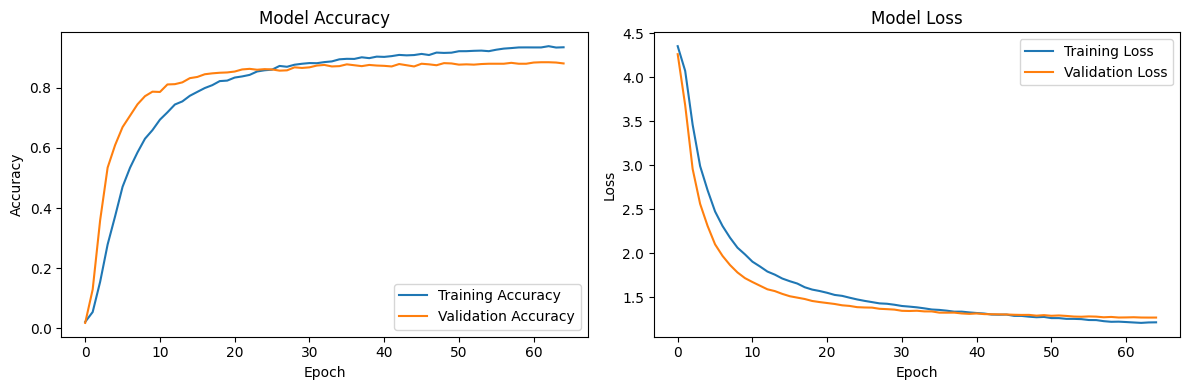

Training history plot saved as 'training_history.png'


In [7]:
# 9) Load Best Model and Evaluate
print("Loading best model and evaluating...")
model_char_bilstm.load_weights("best_char_bilstm.keras")

# Measure inference time
start_time = time.time()
y_prob = model_char_bilstm.predict([x_test_v3, Xte_char], batch_size=256, verbose=0)
inference_time = time.time() - start_time

y_pred = y_prob.argmax(axis=1)

# Calculate metrics
test_acc = accuracy_score(y_test, y_pred)
test_f1_macro = f1_score(y_test, y_pred, average="macro")
test_f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Macro-F1: {test_f1_macro:.4f}")
print(f"Test Weighted-F1: {test_f1_weighted:.4f}")
print(f"Training Time: {training_time:.2f} seconds")
print(f"Inference Time (full test set): {inference_time:.4f} seconds")
print(f"Inference Time per sample: {inference_time/len(x_test_texts)*1000:.4f} ms")

# 10) Calculate Model Size
print("Calculating model size...")

def get_model_size(model):
    # Save model to temporary file and check size
    with tempfile.NamedTemporaryFile(suffix='.h5', delete=False) as tmp:
        model.save(tmp.name)
        model_size = os.path.getsize(tmp.name)
        os.unlink(tmp.name)
    return model_size

def get_model_size_pickle(model):
    # Alternative method: pickle the model
    with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as tmp:
        pickle.dump(model, tmp)
        model_size = os.path.getsize(tmp.name)
        os.unlink(tmp.name)
    return model_size

# Calculate model size
model_size_bytes = get_model_size(model_char_bilstm)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model size: {model_size_bytes:,} bytes ({model_size_mb:.2f} MB)")

# 11) Detailed Classification Report
print("\n" + "=" * 60)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 60)

print(classification_report(y_test, y_pred, target_names=le.classes_, digits=4))

# 12) Save Results to File
results = {
    'test_accuracy': test_acc,
    'test_f1_macro': test_f1_macro,
    'test_f1_weighted': test_f1_weighted,
    'training_time_seconds': training_time,
    'inference_time_seconds': inference_time,
    'inference_time_per_sample_ms': inference_time/len(x_test_texts)*1000,
    'model_size_bytes': model_size_bytes,
    'model_size_mb': model_size_mb,
    'num_parameters': model_char_bilstm.count_params()
}

results_df = pd.DataFrame([results])
print("\nResults summary:")
print(results_df.to_string())

# Save results to CSV
results_df.to_csv('word_char_bilstm_results.csv', index=False)
print("Results saved to 'word_char_bilstm_results.csv'")

# 13) Plot Training History (Extra)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plot saved as 'training_history.png'")